## 1. Import Library 

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics  import accuracy_score,f1_score,precision_score,recall_score
from keras.utils import to_categorical
import numpy as np
from pyvi import ViTokenizer
import regex as re
import string
import pandas as pd
np.set_printoptions(threshold=np.inf)

## 2. Data Proprocesing

#### 2.1. Read the file and divide it into sentences

In [2]:
def ReadData(path):
    df=pd.read_csv(path,encoding='utf-8')
    return df['Regulation Content'][150:264]

> Execute Function

In [3]:
text_data = ReadData("../data/land_law.csv")

In [4]:
text_data.shape

(113,)

### 2.2.Handle extra whitespace,line breaks, punctuation

In [5]:
def clear(sentence):
  # Create a translation table
  translator = str.maketrans('', '', string.punctuation)
  # Remove punctuation
  new_string = sentence.translate(translator)
  # Remove redudant space and break sign
  new_string = re.sub('[\n ]+', ' ', new_string)
  return new_string

> Execute Function

In [6]:
df_train=[]
for line in text_data:
    sentence=str(line)
    sentence=clear(sentence)
    df_train.append(sentence)
df_train[0:2]

['1 Người sử dụng đất\r không được cấp Giấy chứng nhận quyền sử dụng đất quyền sở hữu tài sản gắn\r liền với đất trong các trường hợp sau đây a Đất nông nghiệp\r sử dụng vào mục đích công ích theo quy định tại Điều 179 của\r Luật này b Đất được giao để\r quản lý thuộc các trường hợp quy định tại Điều 7 của Luật này\r trừ trường hợp đất được giao sử dụng chung với đất được giao để quản lý thì được\r cấp Giấy chứng nhận quyền sử dụng đất quyền sở hữu tài sản gắn liền với\r đất đối với phần diện tích đất sử dụng theo quyết định giao đất\r cho thuê đất của cơ quan nhà nước có thẩm quyền c Đất thuê thuê\r lại của người sử dụng đất trừ trường hợp thuê thuê lại đất của chủ đầu tư xây\r dựng kinh doanh kết cấu hạ tầng phù hợp với dự án đầu tư đã được cơ quan có thẩm\r quyền phê duyệt d Đất nhận khoán\r trừ trường hợp được công nhận quyền sử dụng đất tại điểm a khoản\r 2 Điều 181 của Luật này đ Đất đã có quyết\r định thu hồi đất của cơ quan nhà nước có thẩm quyền trừ trường hợp đã quá 03\r năm 

### 2.3 Compound words with meaning

In [7]:
df_train_compound=[]
for line in df_train:
    sentence = ViTokenizer.tokenize(line)
    df_train_compound.append(sentence)

In [126]:
df_train_compound[0:10]

['1 Người sử_dụng đất không được cấp Giấy chứng_nhận quyền sử_dụng đất quyền sở_hữu tài_sản gắn liền với đất trong các trường_hợp sau đây a Đất nông_nghiệp sử_dụng vào mục_đích công_ích theo quy_định tại Điều 179 của Luật này b Đất được giao để quản_lý thuộc các trường_hợp quy_định tại Điều 7 của Luật này trừ trường_hợp đất được giao sử_dụng chung với đất được giao để quản_lý thì được cấp Giấy chứng_nhận quyền sử_dụng đất quyền sở_hữu tài_sản gắn liền với đất đối_với phần diện_tích đất sử_dụng theo quyết_định giao đất cho thuê đất của cơ_quan nhà_nước có thẩm_quyền c Đất thuê thuê lại của người sử_dụng đất trừ trường_hợp thuê thuê lại đất của chủ đầu_tư xây_dựng kinh_doanh kết_cấu_hạ_tầng phù_hợp với dự_án đầu_tư đã được cơ_quan có thẩm_quyền phê_duyệt d Đất_nhận khoán trừ trường_hợp được công_nhận quyền sử_dụng đất tại điểm a khoản 2 Điều 181 của Luật này đ Đất đã có quyết_định thu_hồi đất của cơ_quan nhà_nước có thẩm_quyền_trừ trường_hợp đã quá 03 năm kể từ thời_điểm có quyết_định th

#### 2.4. Create Corpus

In [8]:
def CreateCorpus(Vi):
    tokenizer = Tokenizer(oov_token='<oov>', filters='!“"”#$%&()*+,-./:;<=>?@[\]^`{|}~…')
    tokenizer.fit_on_texts(Vi)
    return tokenizer

>Execute function

In [9]:
df_train_corpus=CreateCorpus(df_train_compound)
print(f"Total Word: {len(df_train_corpus.word_index)+1}")
print(df_train_corpus.word_index)

Total Word: 1344
{'<oov>': 1, 'đất': 2, 'sử_dụng': 3, 'có': 4, 'của': 5, 'quy_định': 6, 'được': 7, 'và': 8, 'theo': 9, 'cho': 10, 'thuê': 11, 'quyền': 12, 'đất_đai': 13, 'các': 14, 'cấp': 15, 'này': 16, 'về': 17, 'thực_hiện': 18, 'luật': 19, 'tại': 20, 'điều': 21, 'với': 22, 'giao': 23, 'pháp_luật': 24, 'để': 25, 'nhà_nước': 26, 'thì': 27, 'không': 28, 'tổ_chức': 29, 'việc': 30, 'quản_lý': 31, 'trong': 32, 'trường_hợp': 33, 'đối_với': 34, 'xây_dựng': 35, 'cơ_quan': 36, 'khoản': 37, 'nhân_dân': 38, 'đã': 39, 'sau': 40, '1': 41, '2': 42, 'đầu_tư': 43, 'mục_đích': 44, 'người': 45, 'ủy_ban': 46, 'thẩm_quyền': 47, 'phải': 48, 'a': 49, 'giấy': 50, 'chứng_nhận': 51, 'b': 52, 'ở': 53, 'tiền': 54, 'quy_hoạch': 55, 'thời_hạn': 56, 'hoặc': 57, '3': 58, 'tài_sản': 59, 'cá_nhân': 60, 'sở_hữu': 61, 'khu': 62, 'công_trình': 63, 'quyết_định': 64, 'khác': 65, 'rừng': 66, 'gắn': 67, 'liền': 68, 'chuyển': 69, 'nông_nghiệp': 70, 'c': 71, 'giá': 72, 'cơ_sở': 73, 'năm': 74, 'nhà': 75, 'mà': 76, 'tỉnh': 77, 

#### 2.5. Generate input data for training

> Model n-gram

In [10]:
def CreateInput(text_data):
    input_sequences = []
    for line in text_data:
        token_list = df_train_corpus.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences

> Execute Function

In [11]:
input_sequences=CreateInput(df_train_compound)
print(input_sequences[0:2])

[[41, 45], [41, 45, 3]]


> Longest sentence

In [12]:
max_sequence_len = max([len(seq) for seq in input_sequences])
print(max_sequence_len)

1352


>Padding

In [13]:
def Padding(Vi):
    input_sequences = np.array(pad_sequences(Vi, maxlen=max_sequence_len, padding='pre'))
    return input_sequences

> Execute Function

In [14]:
sequence=Padding(input_sequences)

In [15]:
print(sequence[0:2])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0 

>Split data into x_train and y_train

In [135]:
X, y = sequence[:, :-1],sequence[:, -1]
print(X.shape)
print(y.shape)


(29700, 1351)
(29700,)


> Convert y_train to one hot vector

In [136]:
y =to_categorical(y, num_classes=len(df_train_corpus.word_index)+1)
print(y.shape)

(29700, 1344)


## 3 Built Model

### 3.1. Design configuration for RNN network

In [137]:
total_words=len(df_train_corpus.word_index)+1
num_classes=len(df_train_corpus.word_index)+1
embedding_size =100
num_RNN_units = 128
epochs=500
dropout=0.2

### 3.2 RNN Model

In [138]:
model = Sequential()
model.add(Embedding(total_words, embedding_size, name='embedding_layer')) 
model.add(Dropout(dropout,name='drop_out_layer1'))
model.add(SimpleRNN(num_RNN_units, return_sequences=True, activation='relu', name='rnn_layer_1'))
model.add(Dropout(dropout,name='drop_out_layer2'))
model.add(SimpleRNN(num_RNN_units, activation='relu', name='rnn_layer_2'))
model.add(Dense(num_classes, activation='softmax', name='output_layer'))


### 3.3. Hyperparameter

In [139]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 3.4. Train

 >Monitor the trainning process to stop earlier

In [140]:
# Khởi tạo callback EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='loss',  # Theo dõi mất mát trên tập huấn luyện
    patience=30,          
    restore_best_weights=True  
)

In [141]:
model.fit(X, y,
          epochs=epochs,
          verbose=1,
          batch_size=64,
          validation_split=0.2,
          callbacks=[early_stopping_callback])

Epoch 1/500
929/929 ━━━━━━━━━━━━━━━━━━━━ 606s 649ms/step - accuracy: 0.0701 - loss: 6.2039
Epoch 2/500
929/929 ━━━━━━━━━━━━━━━━━━━━ 598s 644ms/step - accuracy: 0.2206 - loss: 4.5706
Epoch 3/500
929/929 ━━━━━━━━━━━━━━━━━━━━ 596s 642ms/step - accuracy: 0.2938 - loss: 3.9790
Epoch 4/500
929/929 ━━━━━━━━━━━━━━━━━━━━ 597s 642ms/step - accuracy: 0.3381 - loss: 3.5772
Epoch 5/500
929/929 ━━━━━━━━━━━━━━━━━━━━ 594s 639ms/step - accuracy: 0.3804 - loss: 3.2450
Epoch 6/500
929/929 ━━━━━━━━━━━━━━━━━━━━ 591s 636ms/step - accuracy: 0.4110 - loss: 2.9518
Epoch 7/500
929/929 ━━━━━━━━━━━━━━━━━━━━ 594s 640ms/step - accuracy: 0.4376 - loss: 2.7503
Epoch 8/500
929/929 ━━━━━━━━━━━━━━━━━━━━ 593s 638ms/step - accuracy: 0.4469 - loss: 2.5914
Epoch 9/500
929/929 ━━━━━━━━━━━━━━━━━━━━ 593s 639ms/step - accuracy: 0.4714 - loss: 2.4100
Epoch 10/500
929/929 ━━━━━━━━━━━━━━━━━━━━ 594s 639ms/step - accuracy: 0.4872 - loss: 2.2917
Epoch 11/500
929/929 ━━━━━━━━━━━━━━━━━━━━ 594s 639ms/step - accuracy: 0.5030 - loss: 2.16

>Network Architecture

In [142]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 1351, 100)      │       134,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_out_layer1 (Dropout)       │ (None, 1351, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_1 (SimpleRNN)         │ (None, 1351, 128)      │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_out_layer2 (Dropout)       │ (None, 1351, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_2 (SimpleRNN)         │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1344)           │       173,376 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,109,954 (4.23 MB)

 Trainable params: 369,984 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 739,970 (2.82 MB)

> Dump file model_RNN_generate_text.h5

In [143]:
model.save("../model/model_RNN_generate_text.h5")

> Load model_RNN_generate_text.h5

In [144]:
model_generate=load_model("../model/model_RNN_generate_text.h5")

> Network Architecture Diagram

In [145]:
# Tạo đồ thị cho mô hình
plot_model(model_generate, to_file='../picture_model/model_RNN_generate_text.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


> Get the weight of the embedding layer

In [146]:
weights = model_generate.layers[0].get_weights()[0]
# Giảm chiều dữ liệu sử dụng t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(weights)
print(embeddings_2d[1:3])

[[ 0.46711943  0.06729197]
 [-2.9613383  -0.96068925]]


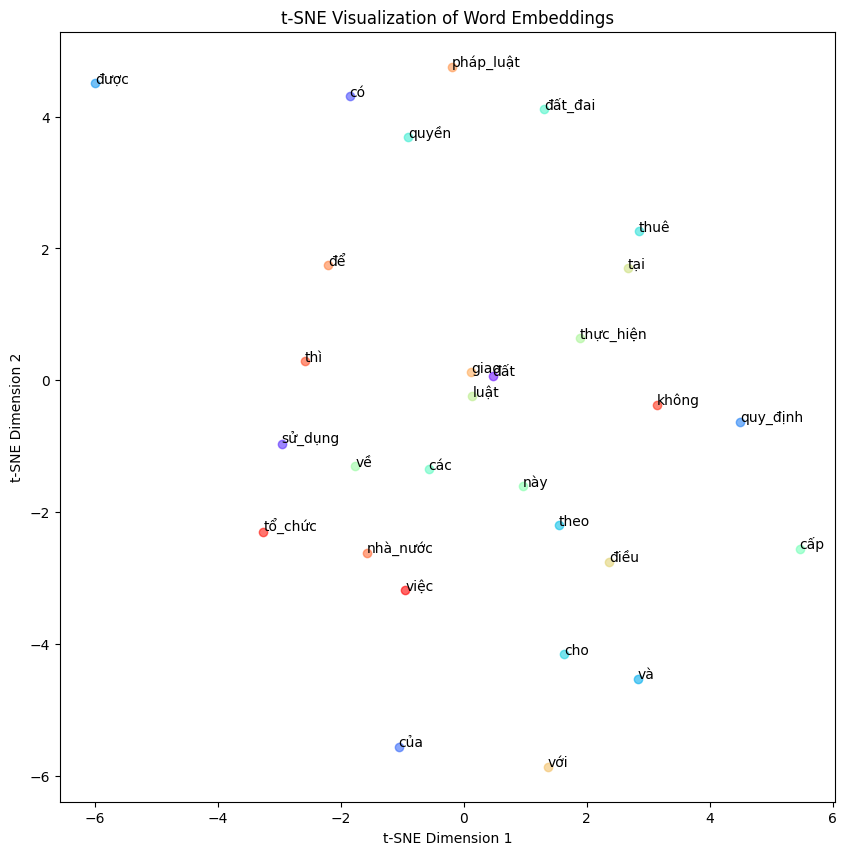

In [147]:
# Vẽ trực quan hóa với nhãn từ
# Màu cho mỗi từ
colors = plt.cm.rainbow(np.linspace(0, 1, 30))
plt.figure(figsize=(10, 10))
for i in range(1,30):  
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='o', color=colors[i], alpha=0.6)
    plt.annotate(df_train_corpus.index_word[i+1], (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Word Embeddings')
plt.show()


### 3.5 Evaluation 

> Data Preprocessing sample

In [148]:
def Preprocessing(sentence):
    sentence=ViTokenizer.tokenize(sentence)
    sentence=df_train_corpus.texts_to_sequences([sentence])
    sentence = Padding(sentence)
    return sentence

> Generate 20 word

In [149]:
next_words = 20
seed_text="Trường Đại học Sư phạm Kỹ thuật TP HCM với 53 năm xây dựng và phát triển đã đào tạo"
y_predict=[]
def Recommend(seed_text):
    for _ in range(next_words):
        token_list = Preprocessing(seed_text.lower())
        predicted_probs = model_generate.predict(token_list)
        predicted_word = df_train_corpus.index_word[np.argmax(predicted_probs)]
        seed_text += " " + predicted_word
        y_predict.append(predicted_word)
    return seed_text


> Recommend text

In [150]:
y_result=Recommend(seed_text)
print(y_result)
print(y_predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Trường Đại học Sư phạm Kỹ thuật TP HCM với 53 năm xây dựng và phát triển đã đào tạo giáo_dục xác_định_giá đất khi xây_dựng theo quy_định của pháp_luật về bảo_vệ môi_trường và quy_định khác của pháp_luật có liên_quan 8
['giáo_dục', 'xác_địn

#### 3.5 Evaluating 

In [151]:
# y_true = ["came","to","Vietnam","to","find","a","reliable","partner", "to","receive"]
# accuracy = accuracy_score(y_true, y_predict)
# print(f'Accuracy: {accuracy:.4f}')

# precision = precision_score(y_true, y_predict, average='weighted')
# print(f"Precision: {precision:.4f}")

# recall = recall_score(y_true, y_predict, average='weighted')
# print(f"Recall: {recall:.4f}")

# f1score = f1_score(y_true, y_predict, average='weighted')
# print(f"F1-score: {f1score}")